# Bounds on the Probability of Functions of RVs

In [1]:
import numpy as np
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

# Sum of Uniform Random Variables

In [2]:
def plot_sum_uniform():
    x = np.linspace(0, 6, 50)
    _s = np.linspace(0, 13, 50)
    fig, ax = plt.subplots(3)
    plots = {k: ax[0].plot(x, np.zeros(len(x)), label=k)[0] for k in ["x", "y", "s-x"]}
    plot_g = {k: ax[1].plot(x, np.zeros(len(x)), label=k)[0] for k in ["lower", "upper"]}
    plot_horizontal_cdf_s = {k: ax[1].plot(x, np.zeros(len(x)))[0] for k in ["lower", "upper"]}
    plot_cdf_s = {k: ax[2].plot(_s, np.zeros(len(_s)))[0] for k in ["lower", "upper"]}
    plot_vertical_s = ax[2].plot([1, 1], [0, 1])[0]
    ax[0].set_ylim([-0.1, 1.1])
    ax[1].set_ylim([-0.1, 1.1])
    ax[2].set_ylim([-0.1, 1.1])
    ax[0].legend()
    #def update_plot(a_x=0, a_y=0, s=1):
    def update_plot(a_x=0, b_x=1, a_y=0, b_y=1, s=2):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        _s_min_lower = np.minimum(a_x+b_y, a_y+b_x)
        _s_min_upper = a_x+a_y
        _s_max_upper = np.maximum(a_x+b_y, a_y+b_x)
        rv_s_lower = stats.uniform(loc=_s_min_lower, scale=b_x+b_y-_s_min_lower)
        rv_s_upper = stats.uniform(loc=_s_min_upper, scale=_s_max_upper-_s_min_upper)
        
        plots['x'].set_ydata(rv_x.pdf(x))
        plots['y'].set_ydata(rv_y.pdf(x))
        plots['s-x'].set_ydata(rv_x.pdf(s-x))
        plot_g["lower"].set_ydata(np.maximum(rv_x.cdf(s-x)+rv_y.cdf(x)-1, 0))
        plot_g["upper"].set_ydata(np.minimum(rv_x.cdf(s-x)+rv_y.cdf(x), 1))
        plot_horizontal_cdf_s["lower"].set_ydata(rv_s_lower.cdf(s))
        plot_horizontal_cdf_s["upper"].set_ydata(rv_s_upper.cdf(s))
        plot_cdf_s["lower"].set_ydata(rv_s_lower.cdf(_s))
        plot_cdf_s["upper"].set_ydata(rv_s_upper.cdf(_s))
        plot_vertical_s.set_xdata([s, s])
    #interact(update_plot, a_x=(0, 5, .1), a_y=(0, 5, .1), s=(0, 12, .1))
    interact(update_plot, a_x=(0, 5, .1), b_x=(0, 6, .1), a_y=(0, 5, .1), b_y=(0, 6, .1), s=(0, 12, .1))

<IPython.core.display.Javascript object>


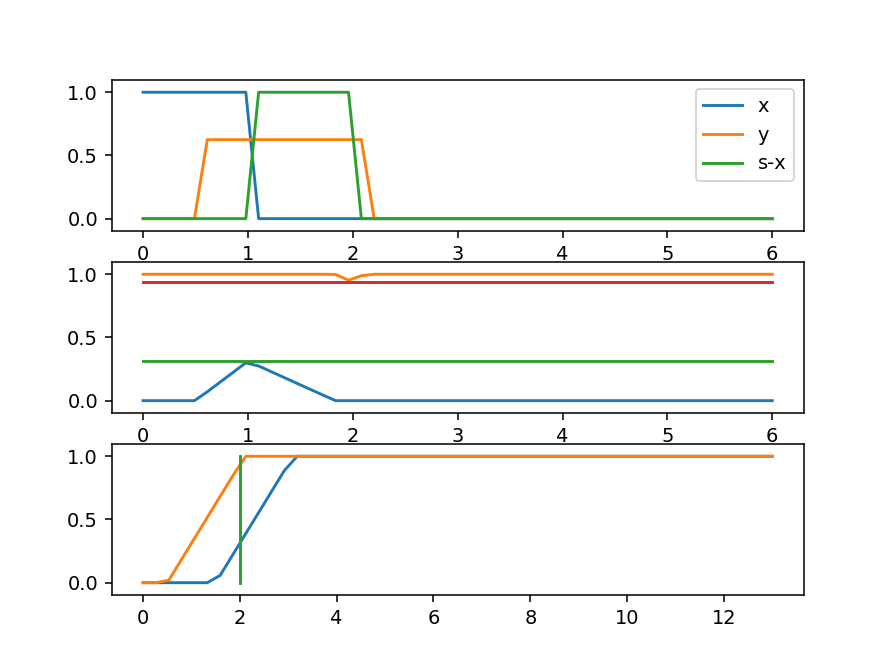

interactive(children=(FloatSlider(value=0.0, description='a_x', max=5.0), FloatSlider(value=1.0, description='…

In [3]:
plot_sum_uniform()

## Optimal Joint Distribution

In [14]:
def copula_lower(a, b, a_x=1, b_x=3, a_y=2, b_y=5, s=1):
    _s_min_lower = np.minimum(a_x+b_y, a_y+b_x)
    rv_s_lower = stats.uniform(loc=_s_min_lower, scale=b_x+b_y-_s_min_lower)
    t = rv_s_lower.cdf(s)
    c = np.minimum(a, b)
    idx_t = np.where(np.logical_and(a >= t, b >= t))
    c[idx_t] = np.maximum(a[idx_t] + b[idx_t] - 1, t)
    return c

def copula_upper(a, b, a_x=1, b_x=3, a_y=2, b_y=5, s=1):
    _s_min_upper = a_x+a_y
    _s_max_upper = np.maximum(a_x+b_y, a_y+b_x)
    rv_s_upper = stats.uniform(loc=_s_min_upper, scale=_s_max_upper-_s_min_upper)
    r = rv_s_upper.cdf(s)
    c = np.minimum(a, b)
    idx_r = np.where(np.logical_and(a <= r, b <= r))
    c[idx_r] = np.maximum(a[idx_r] + b[idx_r] - r, 0)
    return c

In [27]:
from matplotlib.gridspec import GridSpec

def plot_joint_lower_dist():
    xlim = [0, 4]
    ylim = [0, 6]
    fig = plt.figure(num="Joint Distribution Lower Bound")
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    #ax_joint.set_xlabel("$\\tilde{X}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, num=75, retstep=True)
    y, stepy = np.linspace(*ylim, num=75, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(a_x=1, b_x=3, a_y=2, b_y=5, s=1):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        marg_cdf_x = rv_x.cdf(X)
        marg_cdf_y = rv_y.cdf(Y)
        joint_cdf = copula_lower(marg_cdf_x, marg_cdf_y, a_x=a_x, b_x=b_x, a_y=a_y, b_y=b_y, s=s)
        _gradx = np.gradient(joint_cdf, stepx, axis=0)
        joint_pdf = np.gradient(_gradx, stepy, axis=1)
        marg_x = rv_x.pdf(x)
        marg_y = rv_y.pdf(y)
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.set_xlim(xlim)
        ax_joint.set_ylim(ylim)
        ax_joint.set_xlabel("$X$")
        ax_joint.set_ylabel("$Y$")
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0)#, vmax=1)
        ax_joint.plot([0, s], [s, 0], 'r-')
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        #fig.canvas.draw_idle()
    interact(update_plot, a_x=(0, 2, .1), b_x=(2.5, 4, .1), a_y=(0, 2, .1), b_y=(3, 6, .1), s=(0, 10, .1))
    #plt.colorbar()
    
def plot_joint_upper_dist():
    xlim = [0, 4]
    ylim = [0, 6]
    fig = plt.figure(num="Joint Distribution Upper Bound")
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    #ax_joint.set_xlabel("$\\tilde{X}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, num=75, retstep=True)
    y, stepy = np.linspace(*ylim, num=75, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(a_x=1, b_x=3, a_y=2, b_y=5, s=1):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        marg_cdf_x = rv_x.cdf(X)
        marg_cdf_y = rv_y.cdf(Y)
        joint_cdf = copula_upper(marg_cdf_x, marg_cdf_y, a_x=a_x, b_x=b_x, a_y=a_y, b_y=b_y, s=s)
        _gradx = np.gradient(joint_cdf, stepx, axis=0)
        joint_pdf = np.gradient(_gradx, stepy, axis=1)
        marg_x = rv_x.pdf(x)
        marg_y = rv_y.pdf(y)
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.set_xlim(xlim)
        ax_joint.set_ylim(ylim)
        ax_joint.set_xlabel("$X$")
        ax_joint.set_ylabel("$Y$")
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0)#, vmax=1)
        ax_joint.plot([0, s], [s, 0], 'r-')
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        #fig.canvas.draw_idle()
    interact(update_plot, a_x=(0, 2, .1), b_x=(2.5, 4, .1), a_y=(0, 2, .1), b_y=(3, 6, .1), s=(0, 10, .1))
    #plt.colorbar()

<IPython.core.display.Javascript object>


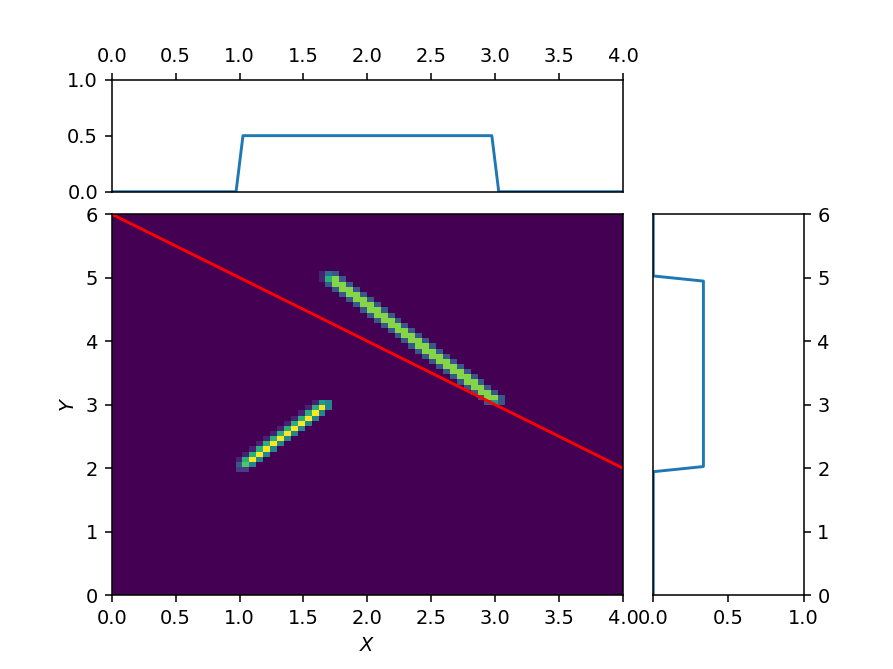

interactive(children=(FloatSlider(value=1.0, description='a_x', max=2.0), FloatSlider(value=3.0, description='…

In [28]:
plot_joint_lower_dist()

<IPython.core.display.Javascript object>


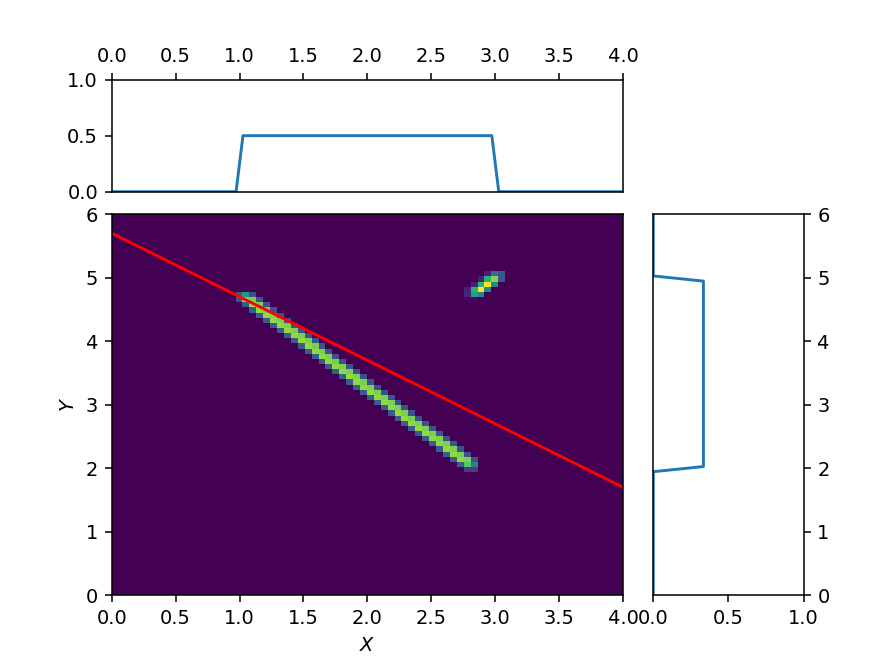

interactive(children=(FloatSlider(value=1.0, description='a_x', max=2.0), FloatSlider(value=3.0, description='…

In [29]:
plot_joint_upper_dist()

# Product of Uniform Random Variables

In [7]:
def plot_product_uniform():
    x = np.linspace(0.01, 3, 75)
    _s = np.linspace(0, 5, 75)
    fig, ax = plt.subplots(3)
    plots = {k: ax[0].plot(x, np.zeros(len(x)), label=k)[0] for k in ["x", "y", "s/x"]}
    plot_g = {k: ax[1].plot(x, np.zeros(len(x)), label=k)[0] for k in ["lower", "upper"]}
    plot_horizontal_cdf_s = {k: ax[1].plot(x, np.zeros(len(x)))[0] for k in ["lower", "upper"]}
    plot_cdf_s = {k: ax[2].plot(_s, np.zeros(len(_s)))[0] for k in ["lower", "upper"]}
    plot_vertical_s = ax[2].plot([1, 1], [0, 1])[0]
    ax[0].set_ylim([-0.1, 1.1])
    ax[1].set_ylim([-.1, 1.1])
    ax[2].set_ylim([-0.1, 1.1])
    ax[0].legend()
    def update_plot(a_x=0, b_x=1, a_y=0, b_y=1, s=2):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        _s_min_lower = np.minimum(a_x*b_y, a_y*b_x)
        _s_min_upper = a_x*a_y
        _s_max_upper = np.maximum(a_x*b_y, a_y*b_x)
        rv_s_lower = stats.uniform(loc=_s_min_lower, scale=b_x*b_y-_s_min_lower)
        rv_s_upper = stats.uniform(loc=_s_min_upper, scale=_s_max_upper-_s_min_upper)
        yopt = np.sqrt(s*(b_y-a_y)/(b_x-a_x))
        xopt = np.sqrt(s*(b_x-a_x)/(b_y-a_y))
        
        plots['x'].set_ydata(rv_x.pdf(x))
        plots['y'].set_ydata(rv_y.pdf(x))
        plots['s/x'].set_ydata(rv_x.pdf(s/x))
        plot_g["lower"].set_ydata(np.maximum(rv_x.cdf(s/x)+rv_y.cdf(x)-1, 0))
        plot_g["upper"].set_ydata(np.minimum(rv_x.cdf(s/x)+rv_y.cdf(x), 1))
        plot_horizontal_cdf_s["lower"].set_ydata(np.maximum(rv_x.cdf(s/b_y), rv_y.cdf(s/b_x)))
        plot_horizontal_cdf_s["upper"].set_ydata(np.minimum(rv_x.cdf(s/a_y), rv_y.cdf(s/a_x)))
        #plot_horizontal_cdf_s["upper"].set_ydata(rv_s_upper.cdf(s))
        plot_cdf_s["lower"].set_ydata(rv_s_lower.cdf(_s))
        plot_cdf_s["upper"].set_ydata(rv_s_upper.cdf(_s))
        plot_vertical_s.set_xdata([s, s])
    #interact(update_plot, a_x=(0, 5, .1), a_y=(0, 5, .1), s=(0, 12, .1))
    interact(update_plot, a_x=(0, 2, .1), b_x=(0, 2, .1), a_y=(0, 2, .1), b_y=(0, 2, .1), s=(0, 11, .1))

<IPython.core.display.Javascript object>


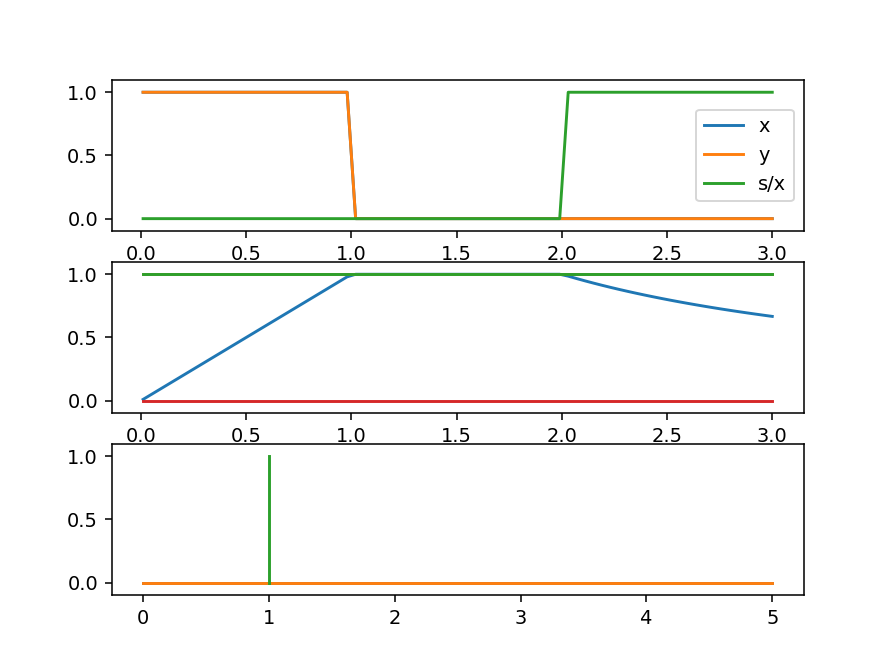

interactive(children=(FloatSlider(value=0.0, description='a_x', max=2.0), FloatSlider(value=1.0, description='…

In [8]:
plot_product_uniform()

In [9]:
def product_uniform_bounds(a_x=0, b_x=1, a_y=0, b_y=1):
    rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
    rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
    s = np.linspace(0, 20, 50)
    g_lower = rv_x.cdf(s/x)+rv_y.cdf(x)-1
    g_upper = rv_x.cdf(s/x)+rv_y.cdf(x)